# Predicting churning customer at Interconnect


## Goals:

1. Predict churn

    - With high competition in the market, the marketing team would like to forecast potential churning customers in order to keep retention rate high. Once potential churning customers identified, they will be offered promotional codes and special plan options to try and retend the users.

    - Marketing team has collected clientele's personal data and our goal is to leverage existing client data to predict churn.<br><br/>

2. Client outflow research

    - Learning the behavior between churn vs active clients may help marketing and product teams to brainstorm better marketing campaigns and design better product plans.
    
        1. Compare monthly payment distribution between churned vs active
        2. Compare telephone and internet users

This is a binary classification problem so will use supervised learning.


<div class="alert alert-block alert-warning">
<b></b> <a class="tocSkip"></a>   
    
> # Contents <a id='back'></a>
> * [Introduction](#intro)
> * [Importing libraries](#Importing-libraries)
> * [Load datasets and examine](#Load-datasets-and-examine)    
> * [Data Processing](#Data-Processing)
> * [Exploratory Data Analysis](#Exploratory-Data-Analysis)
> * [Split transform and scale data](#Split-transform-and-scale-data)
> * [Addressing imbalance class of target](#Addressing-imbalance-class-of-target)
> * [Model 1 Baseline model](#Model-1-Baseline-model)
> * [Model 2 Logistic Regression ](#Model-2-Logistic-Regression )
> * [Model 3 Random Forest Classifier](#Model-3-Random-Forest-Classifier)
> * [Model 4 LightGBM Classifier ](#Model-4-LightGBM-Classifier)
> * [Model 5 Catboost Classifier](#Model-5-Catboost-Classifier)
> * [Model selection and optimal threshold](#Model-selection-and-optimal-threshold)
> * [Conclusion](#Conclusion)

# Importing libraries

In [1]:
# Standard library imports
import pandas as pd
import numpy as np
import warnings

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    make_scorer,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
)
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier

# Third-party libraries
from scipy.stats import randint
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [2]:
# Run this if returns imblearn error ''sklearn.utils._param_validation''

# !pip uninstall scikit-learn --yes
# !pip uninstall imblearn --yes
# !pip install scikit-learn==1.2.2
# !pip install imblearn


# Load datasets and examine

In [3]:
try:
    raw_contract = pd.read_csv('/Users/dankeichow/Documents/triple_ten_ds_project/Working/final_project/contract.csv')
    raw_internet = pd.read_csv('/Users/dankeichow/Documents/triple_ten_ds_project/Working/final_project/internet.csv')
    raw_personal = pd.read_csv('/Users/dankeichow/Documents/triple_ten_ds_project/Working/final_project/personal.csv')
    raw_phone = pd.read_csv('/Users/dankeichow/Documents/triple_ten_ds_project/Working/final_project/phone.csv')

except:
    raw_contract = pd.read_csv('/datasets/final_provider/contract.csv')
    raw_internet = pd.read_csv('/datasets/final_provider/internet.csv')
    raw_personal = pd.read_csv('/datasets/final_provider/personal.csv')
    raw_phone = pd.read_csv('/datasets/final_provider/phone.csv')

### Examine First dataset: Contract

In [4]:
raw_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
raw_contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


At a quick glance, there are 7043 entries in `contract` file with 8 columns. No missing values. However, may want to update data type for the below:

1. **BeginDate** from object to datetime
2. **EndDate from** object to datetime
3. **TotalCharges** from object to datetime
4. **Type, PaperlessBilling, PaymentMethod** from object to categorical

I will change the datatype to categorical in preparation of machine learning models such as Catboost and LightGBM. In addition, converting datatype from object to categorical reduces memory usage. Categorical data types store categories as integers and use a mapping table

### Examine dataset 2: Internet

In [6]:
raw_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [7]:
raw_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In the second dataset, `internet` there are 5517 entries and 8 columns. No missing values.

However, there are approximately 1.5k+ less entries than first dataset, `contract`; suggesting that not all clients subscribe to internet service.

Again, will have to convert the datatype for all columns to categorical.

### Examine dataset 3: personal

In [8]:
raw_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [9]:
raw_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


`personal` dataset has 7043 entries with 5 columns. This data seems to provide general information of the client. Will convert datatype to categorical.

### Examine dataset 4: phone

In [10]:
raw_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [11]:
raw_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


`phone` dataset has 6361 entries with 2 columns.

Again, this number does not match our `contract` dataset suggesting that not all clients have subscribed to telephone service. Will have to convert the datatype to categorical.

### Conclusion after examining raw data

We have around 7k clients and there is discrepancy in **contract** table with **internet** and **phone** table. After clarifying with the marketing team, confirmed that the missing records mean those clients did not subscribe to internet or phone services. 

We will have to change data type accordingly in the next step and fill missing values with 'non sub' as I will treat them as not subscribing to our service.

Next step...

**Features and target**
- Data is stored in different files and we will merge them into a single dataframe to capture all features

- These are the features 'customderid', 'type', 'paperlessbilling', 'paymentmethod', 'monthlycharges',
       'totalcharges', 'duration', 'internetservice', 'onlinesecurity',
       'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv',
       'streamingmovies', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'multiplelines'
       
- There is no target column. We can create **churned** column by looking into **enddate** column
    - We will convert **No** to 0 to indicate not churned / active user
    - We will convert rows with enddate to 1 to indicate churned
    
- We can create additional feature **duration of subscription** by calculating the difference between enddate and begindate

# Data Processing

### Convert datatypes for file 1: contract

In [12]:
# Lower case all columns for ease of working with columns
raw_contract.rename(columns = lambda x: x.lower(), inplace=True)

# Convert datatype for columns
raw_contract['begindate'] = pd.to_datetime(raw_contract['begindate'])

raw_contract['totalcharges'] = pd.to_numeric(raw_contract['totalcharges'], errors='coerce')

I will save converting to categorical type after merging all tables. As we noticed earlier, there are discrepancies in terms of rows between contract, internet and telephone files. Will fill in those missing values after merging that table then convert to category

In [13]:
raw_contract

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60


In [14]:
# Create target - churn

# Duplicate the enddate column
raw_contract['churn'] = raw_contract['enddate']

# Assign 0 to represent active users and 1 as churn users
raw_contract['churn']  = np.where(raw_contract['churn'] == 'No', 0, 1)

In [15]:
# Create duration

# Since the contract information is valid as of February 1, 2020, will replace the date for existing user

raw_contract['enddate_revised'] = raw_contract['enddate']

raw_contract['enddate_revised'] = raw_contract['enddate_revised'].apply(lambda x: '2020-02-01' if x == 'No' else x)

raw_contract['enddate_revised'] = pd.to_datetime(raw_contract['enddate_revised'], format='ISO8601')

raw_contract['duration'] = (raw_contract['enddate_revised'] - raw_contract['begindate']).dt.days

In [16]:
# Sanity check

raw_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   object        
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7032 non-null   float64       
 8   churn             7043 non-null   int64         
 9   enddate_revised   7043 non-null   datetime64[ns]
 10  duration          7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(5)
memory usage: 605.4+ KB


It appears that there are some missing values in **totalcharges** column. Will investigate further as before updating the datatype, we have no other missing values.

In [17]:
raw_contract[raw_contract['totalcharges'].isnull()]

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,enddate_revised,duration
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,2020-02-01,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,0,2020-02-01,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,0,2020-02-01,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,0,2020-02-01,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,0,2020-02-01,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,0,2020-02-01,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,0,2020-02-01,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,0,2020-02-01,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,0,2020-02-01,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,0,2020-02-01,0


There are 11 new subscribers that signed up on 2020-02-01, which is the day our marketing team exported the data. Therefore, there are no **totalcharges** for these new clients. As the number of subscribers are very insignificant and their data will not have a significant impact on training our model, will proceed to drop new subscribers.

In [18]:
# Drop new subscribers
raw_contract.dropna(inplace=True)

# Sanity check again
raw_contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7032 non-null   object        
 1   begindate         7032 non-null   datetime64[ns]
 2   enddate           7032 non-null   object        
 3   type              7032 non-null   object        
 4   paperlessbilling  7032 non-null   object        
 5   paymentmethod     7032 non-null   object        
 6   monthlycharges    7032 non-null   float64       
 7   totalcharges      7032 non-null   float64       
 8   churn             7032 non-null   int64         
 9   enddate_revised   7032 non-null   datetime64[ns]
 10  duration          7032 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(5)
memory usage: 659.2+ KB


In [19]:
# Drop irrelevant columns and retain useful features for training

raw_contract = raw_contract.drop(['begindate', 'enddate', 'enddate_revised'], axis=1)
raw_contract.head(4)

,customerid,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,duration
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371


### Convert datatypes for file 2: internet and merge

In [20]:
raw_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [21]:
# Convert column names to lower case for ease of handling

raw_internet.rename(columns = lambda x: x.lower(), inplace=True)


In [22]:
# Merging both tables

contract_internet = pd.merge(left = raw_contract, right = raw_internet, how = 'left' , on = 'customerid')

contract_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7032 non-null   object 
 1   type              7032 non-null   object 
 2   paperlessbilling  7032 non-null   object 
 3   paymentmethod     7032 non-null   object 
 4   monthlycharges    7032 non-null   float64
 5   totalcharges      7032 non-null   float64
 6   churn             7032 non-null   int64  
 7   duration          7032 non-null   int64  
 8   internetservice   5512 non-null   object 
 9   onlinesecurity    5512 non-null   object 
 10  onlinebackup      5512 non-null   object 
 11  deviceprotection  5512 non-null   object 
 12  techsupport       5512 non-null   object 
 13  streamingtv       5512 non-null   object 
 14  streamingmovies   5512 non-null   object 
dtypes: float64(2), int64(2), object(11)
memory usage: 824.2+ KB


In [23]:
# Filling in missing values after merging tables

contract_internet.fillna('non_sub', inplace=True)

In [24]:
contract_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7032 non-null   object 
 1   type              7032 non-null   object 
 2   paperlessbilling  7032 non-null   object 
 3   paymentmethod     7032 non-null   object 
 4   monthlycharges    7032 non-null   float64
 5   totalcharges      7032 non-null   float64
 6   churn             7032 non-null   int64  
 7   duration          7032 non-null   int64  
 8   internetservice   7032 non-null   object 
 9   onlinesecurity    7032 non-null   object 
 10  onlinebackup      7032 non-null   object 
 11  deviceprotection  7032 non-null   object 
 12  techsupport       7032 non-null   object 
 13  streamingtv       7032 non-null   object 
 14  streamingmovies   7032 non-null   object 
dtypes: float64(2), int64(2), object(11)
memory usage: 824.2+ KB


We have merged 2 datasets and filled missing values. Will proceed to map the third one.

### Merge file 3: personal

In [25]:
raw_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [26]:
# Convert into lower case for column names

raw_personal.rename(columns = lambda x: x.lower(), inplace=True)


In [27]:
# Merging tables

contract_internet_personal = pd.merge(left = contract_internet,
                                      right = raw_personal,
                                     how = 'left',
                                     on = 'customerid')

contract_internet_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7032 non-null   object 
 1   type              7032 non-null   object 
 2   paperlessbilling  7032 non-null   object 
 3   paymentmethod     7032 non-null   object 
 4   monthlycharges    7032 non-null   float64
 5   totalcharges      7032 non-null   float64
 6   churn             7032 non-null   int64  
 7   duration          7032 non-null   int64  
 8   internetservice   7032 non-null   object 
 9   onlinesecurity    7032 non-null   object 
 10  onlinebackup      7032 non-null   object 
 11  deviceprotection  7032 non-null   object 
 12  techsupport       7032 non-null   object 
 13  streamingtv       7032 non-null   object 
 14  streamingmovies   7032 non-null   object 
 15  gender            7032 non-null   object 
 16  seniorcitizen     7032 non-null   int64  


### Merge file 4: phone

In [28]:
# Convert column names to lower case

raw_phone.rename(columns = lambda x: x.lower(), inplace=True)

In [29]:
# Merge tables

contract_internet_personal_phone = pd.merge(left = contract_internet_personal,
                                           right = raw_phone,
                                           how = 'left',
                                           on = 'customerid')

contract_internet_personal_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7032 non-null   object 
 1   type              7032 non-null   object 
 2   paperlessbilling  7032 non-null   object 
 3   paymentmethod     7032 non-null   object 
 4   monthlycharges    7032 non-null   float64
 5   totalcharges      7032 non-null   float64
 6   churn             7032 non-null   int64  
 7   duration          7032 non-null   int64  
 8   internetservice   7032 non-null   object 
 9   onlinesecurity    7032 non-null   object 
 10  onlinebackup      7032 non-null   object 
 11  deviceprotection  7032 non-null   object 
 12  techsupport       7032 non-null   object 
 13  streamingtv       7032 non-null   object 
 14  streamingmovies   7032 non-null   object 
 15  gender            7032 non-null   object 
 16  seniorcitizen     7032 non-null   int64  


In [30]:
# Fill in missing values

contract_internet_personal_phone.fillna('non_sub', inplace=True)

In [31]:
# Convert data type to category for object columns

# Get a list of column names printed
contract_internet_personal_phone.columns

Index(['customerid', 'type', 'paperlessbilling', 'paymentmethod',
       'monthlycharges', 'totalcharges', 'churn', 'duration',
       'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'gender',
       'seniorcitizen', 'partner', 'dependents', 'multiplelines'],
      dtype='object')

In [32]:
# Convert to data type category 

col_full = ['type', 'paperlessbilling', 'paymentmethod',
       'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'gender', 'partner', 'dependents', 'multiplelines', 'customerid']

for each_col in col_full:
    contract_internet_personal_phone[each_col] = contract_internet_personal_phone[each_col].astype('category')

In [33]:
# Sanity check

contract_internet_personal_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerid        7032 non-null   category
 1   type              7032 non-null   category
 2   paperlessbilling  7032 non-null   category
 3   paymentmethod     7032 non-null   category
 4   monthlycharges    7032 non-null   float64 
 5   totalcharges      7032 non-null   float64 
 6   churn             7032 non-null   int64   
 7   duration          7032 non-null   int64   
 8   internetservice   7032 non-null   category
 9   onlinesecurity    7032 non-null   category
 10  onlinebackup      7032 non-null   category
 11  deviceprotection  7032 non-null   category
 12  techsupport       7032 non-null   category
 13  streamingtv       7032 non-null   category
 14  streamingmovies   7032 non-null   category
 15  gender            7032 non-null   category
 16  seniorcitizen     7032 n

In [34]:
# Make a copy of the table for back up and future use

processed_user = contract_internet_personal_phone.copy()

We have sucessfully merged tables, converted data types and filled in missing values.

Categorical features:
`type`, `paperlessbilling`, `paymentmethod`, `internetservice`, `onlinesecurity`, `onlinebackup`, `deviceprotection`, `techsupport`, `streamingtv`, `streamingmovies`, `gender`, `seniorcitizen`, `partner`, `dependents`, `multiplelines`

Numerical features: `monthlycharges`, `monthlycharges`

# Exploratory Data Analysis

First, let's look at how many churn vs active users.

In [35]:
processed_user['churn'].value_counts()

churn
0    5163
1    1869
Name: count, dtype: int64

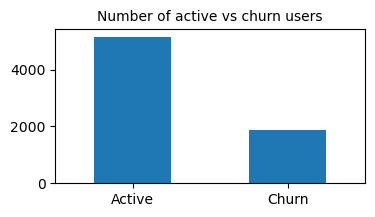

In [36]:
### Will use a graph to visualize the numbers

plt.figure(figsize=(4,2))
processed_user['churn'].value_counts().plot(kind='bar')
plt.title('Number of active vs churn users', fontsize=10)
plt.xticks(ticks=[0,1], labels=['Active','Churn'], rotation=0, fontsize=10)
plt.xlabel('')
plt.show()

At a quick glance, we can see that there is an imbalance of users group. We have 5163 active users and 1869 churned users. We have to check whether there is imbalance of users group because **churn** column will be our target column. If there is an imbalance of class, the model cannot learn the minority class well and may always predict the dominate class. We will address imbalance of class with SMOTE and upsampling at a later stage for better model training.


### Exploring data with sweetviz

**Sweetviz** one of the automated libraries that helps with exploratory data analysis step. Therefore, I will leverage this library to generate charts to understand features distribution.

In [37]:
# pip install sweetviz

                                             |      | [  0%]   00:00 -> (? left)


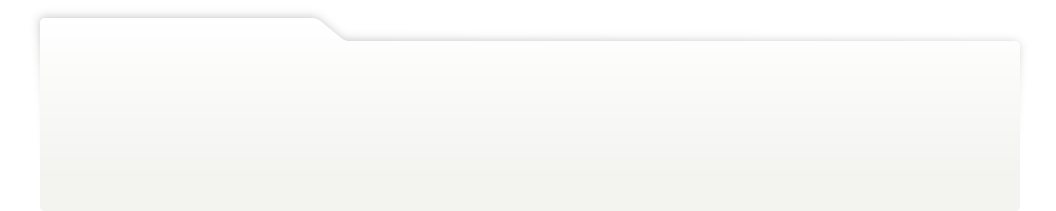
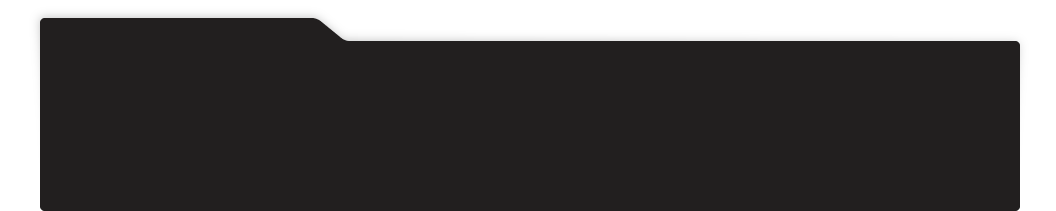
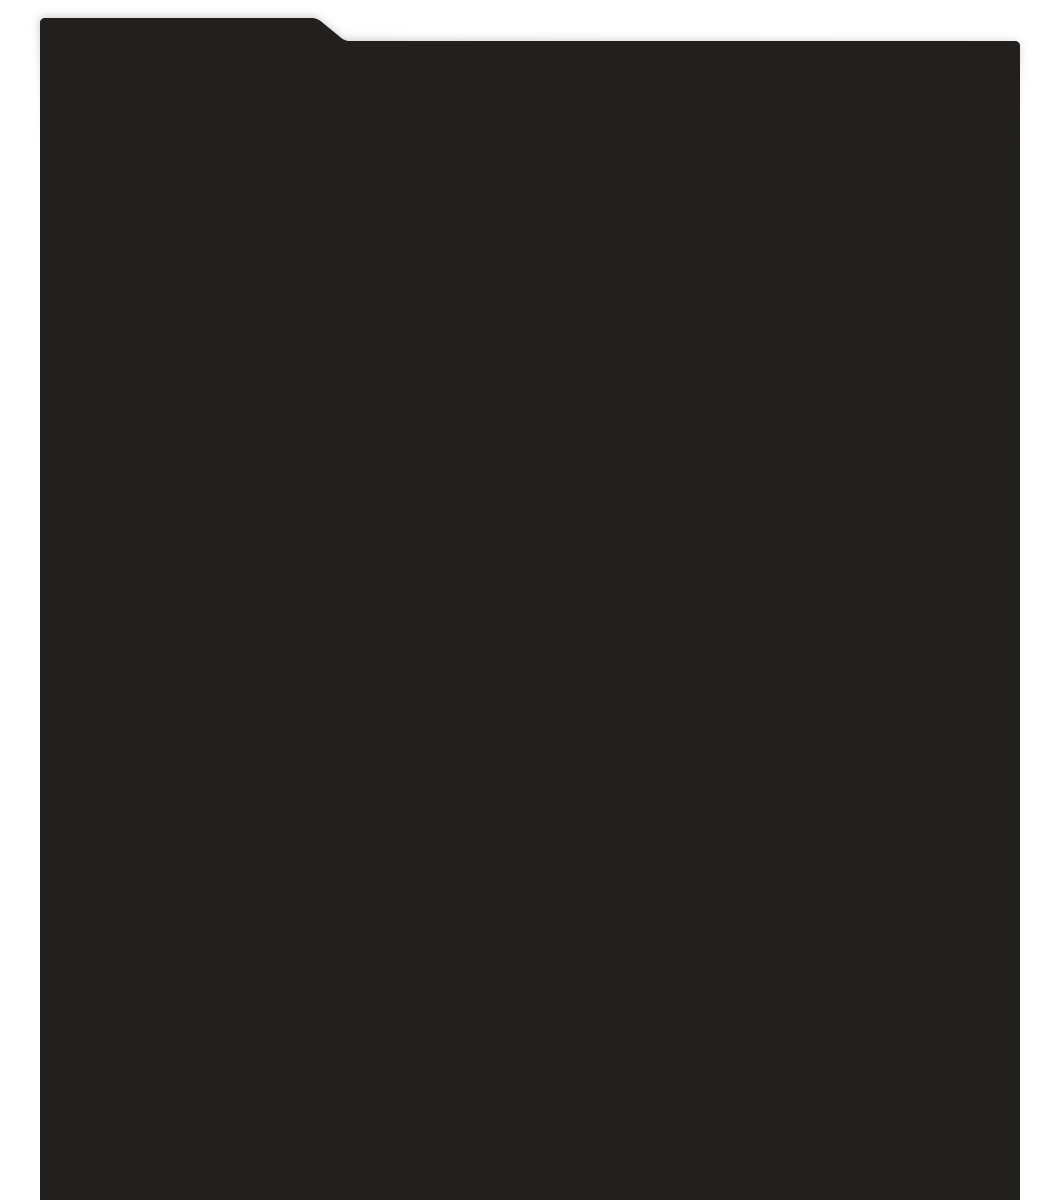
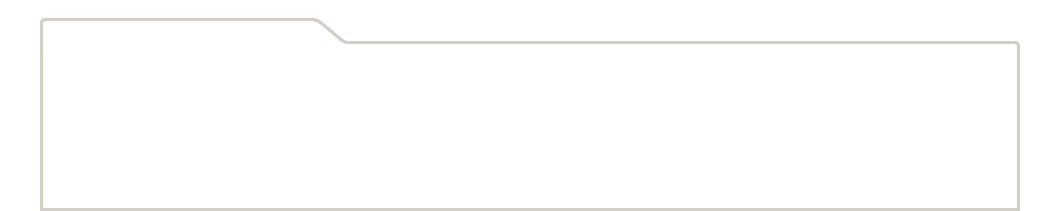
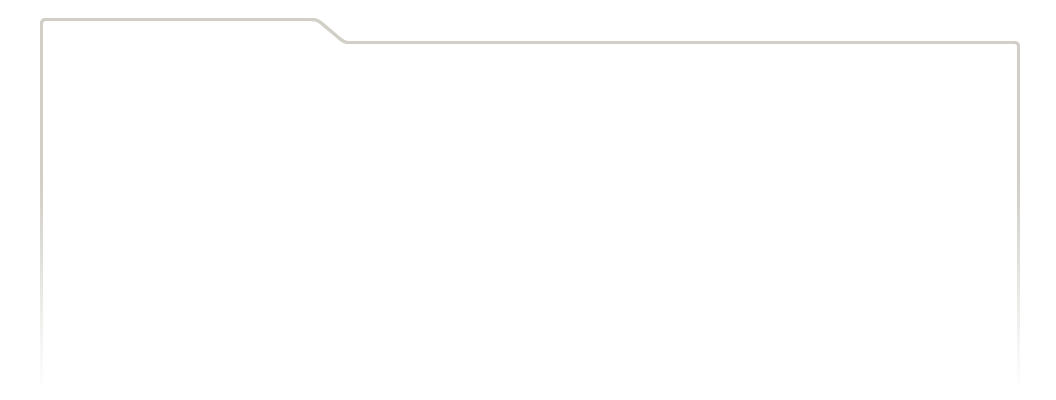
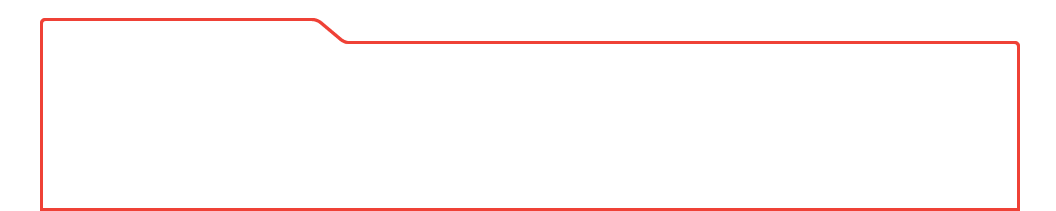
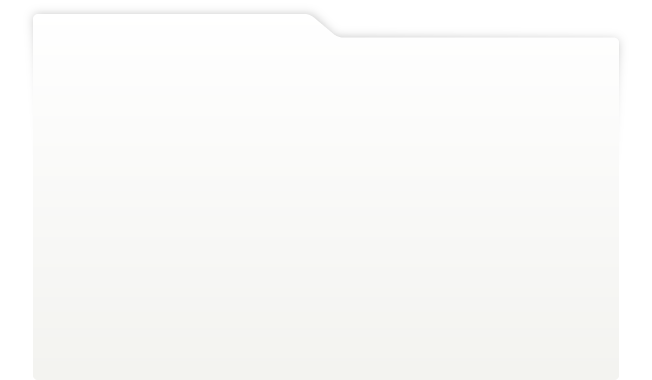
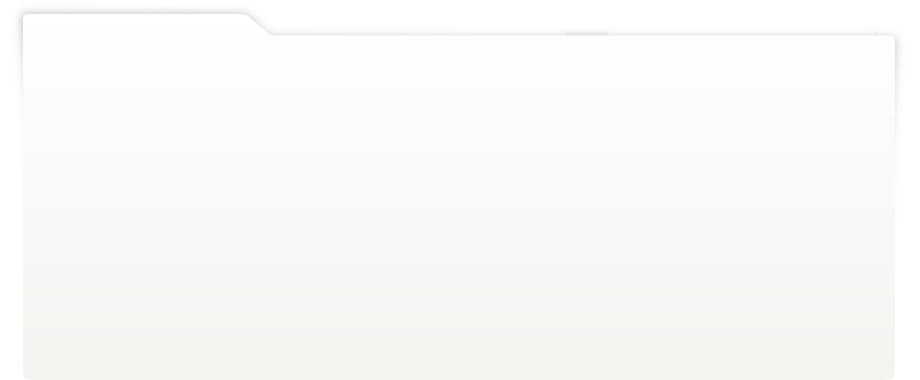
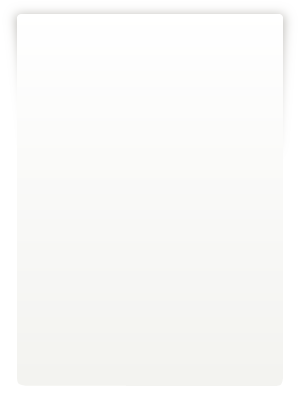
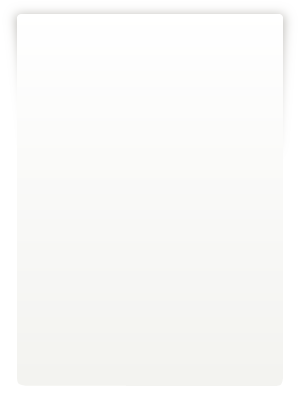
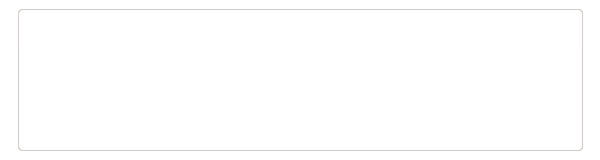
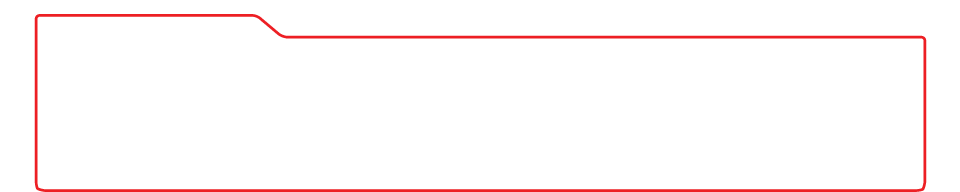
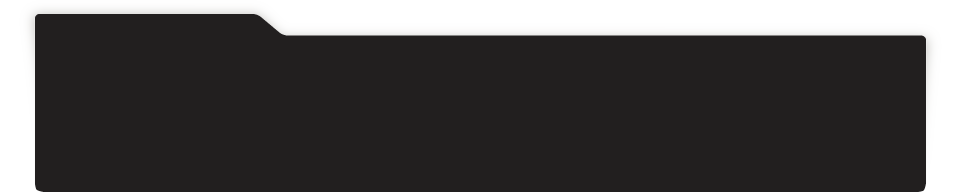
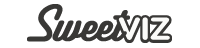
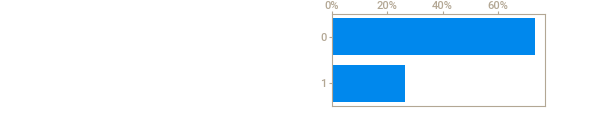
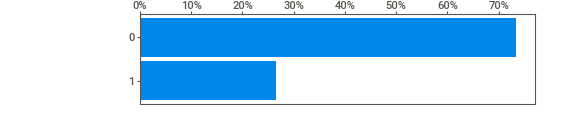
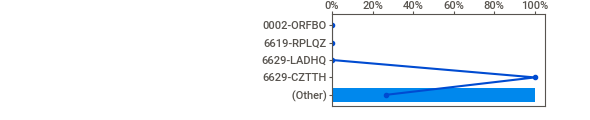
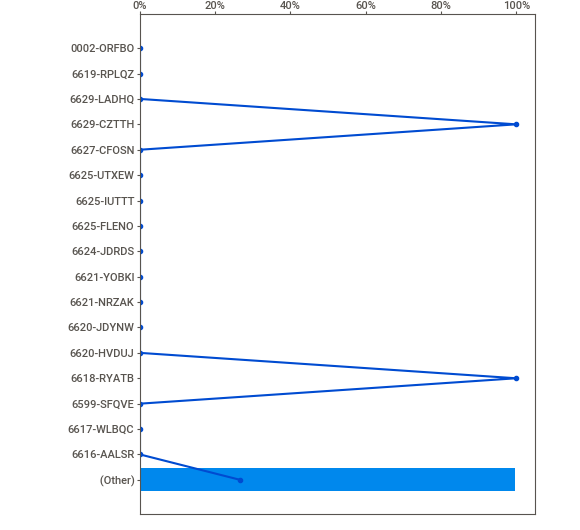
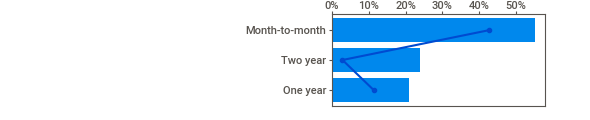
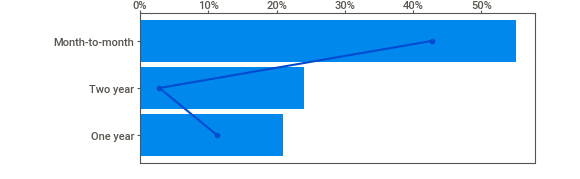
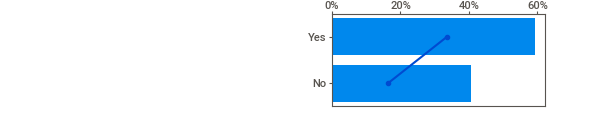
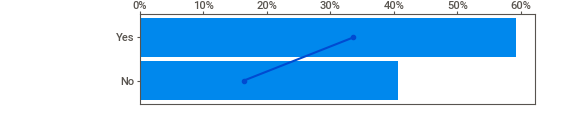
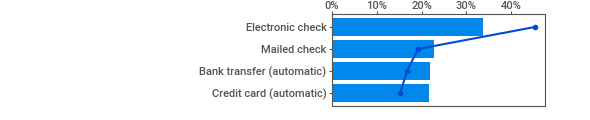
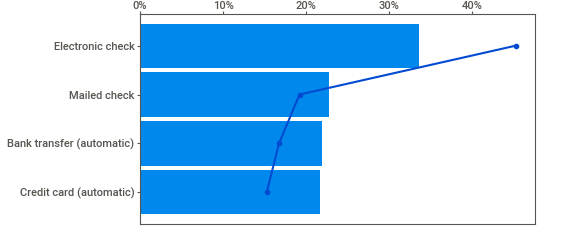
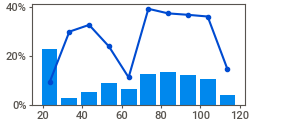
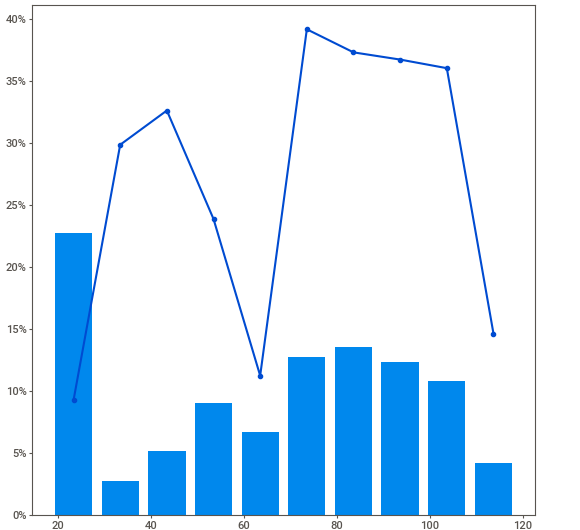
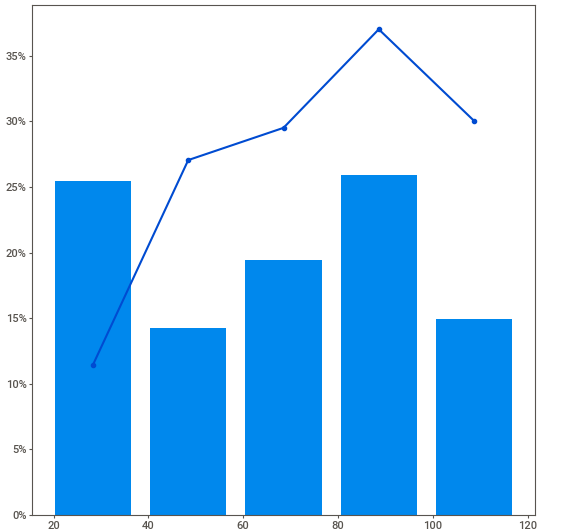
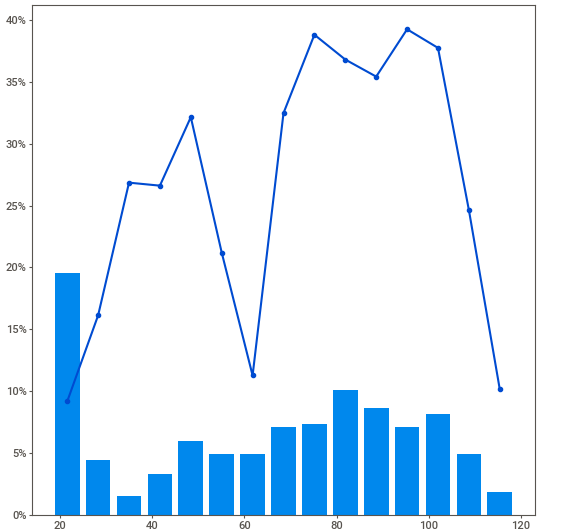
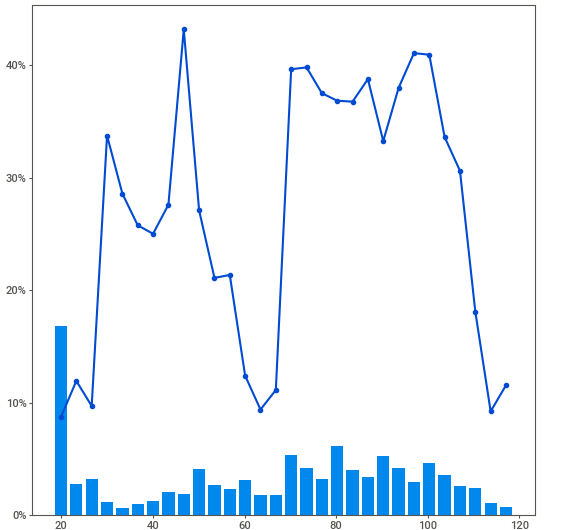
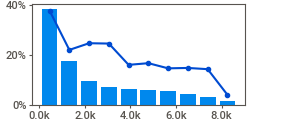
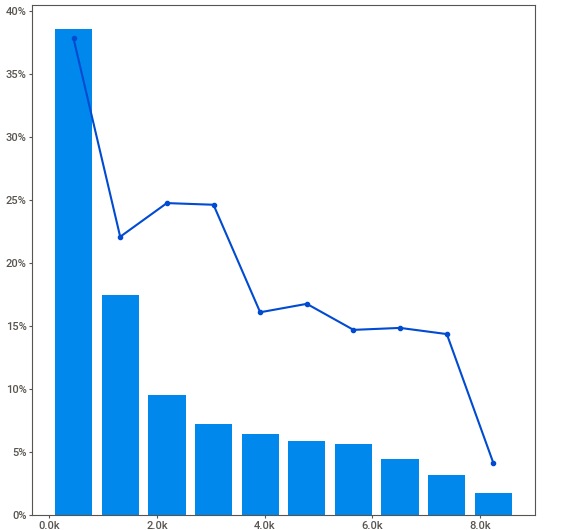
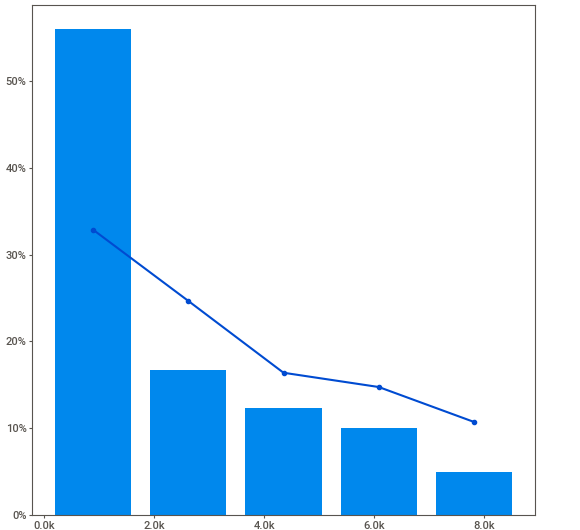
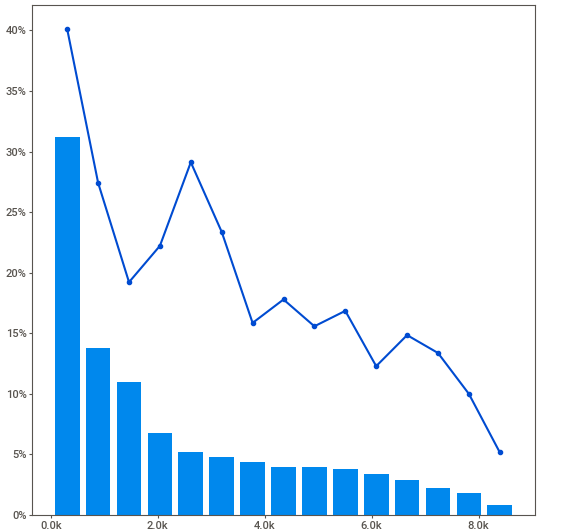
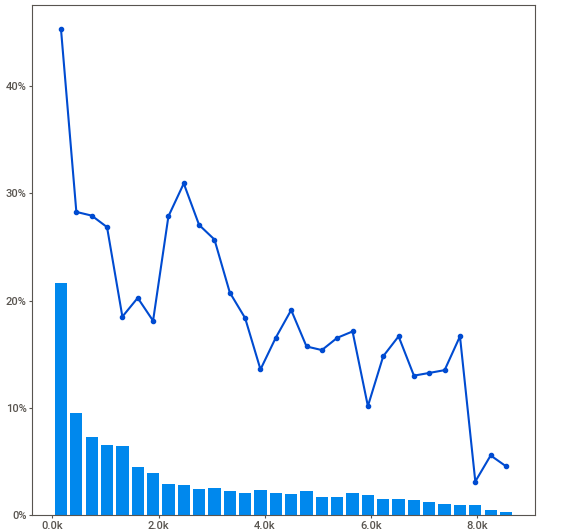
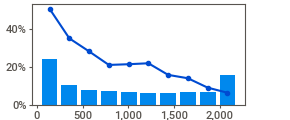
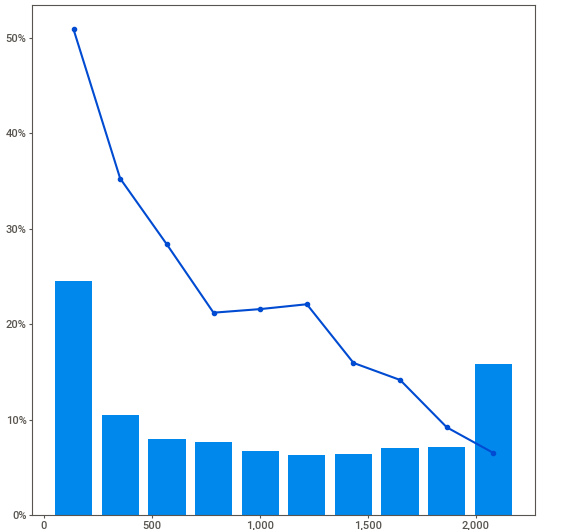
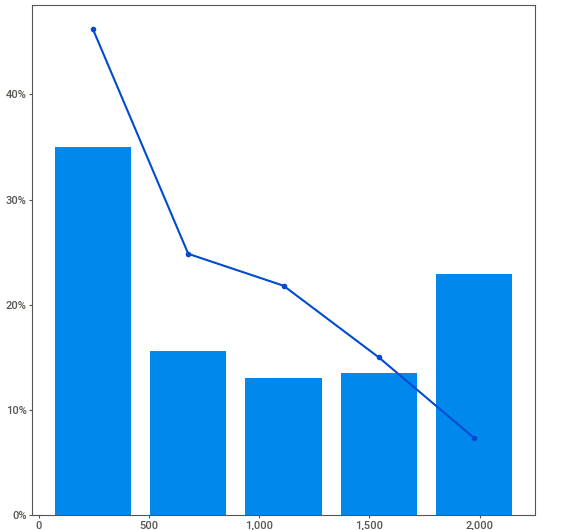
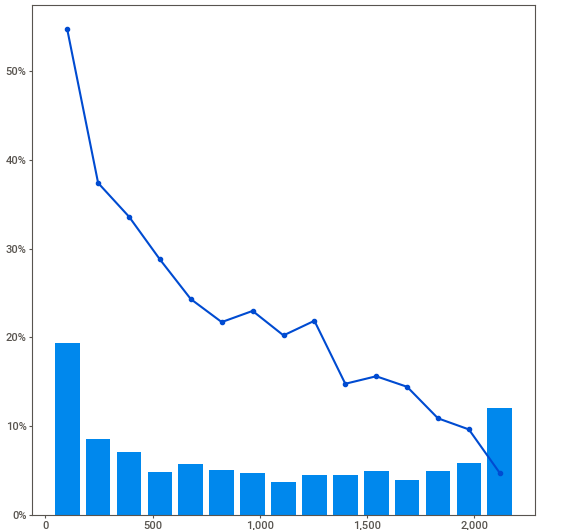
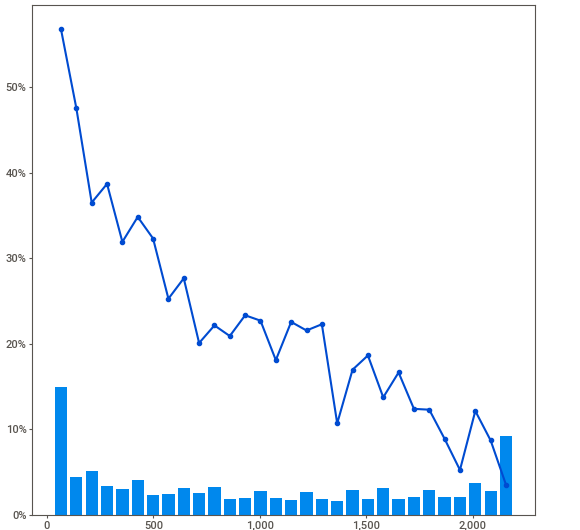
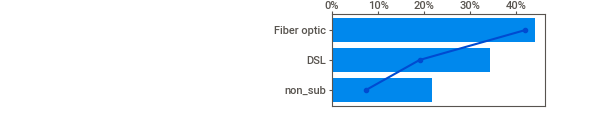
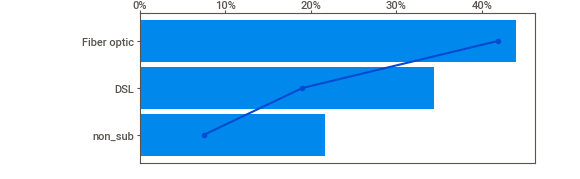
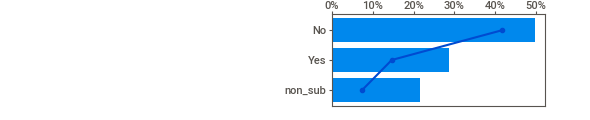
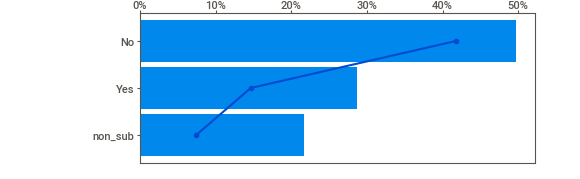
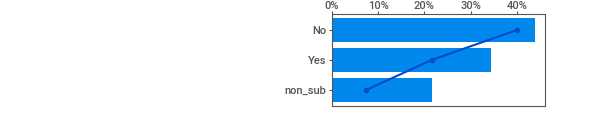
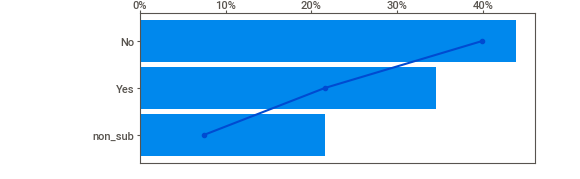
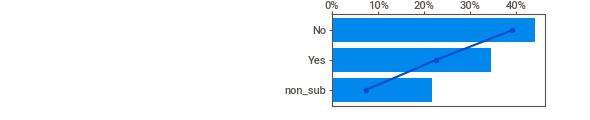
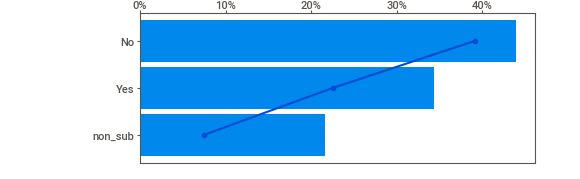
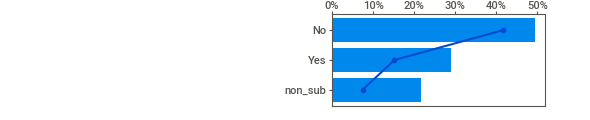
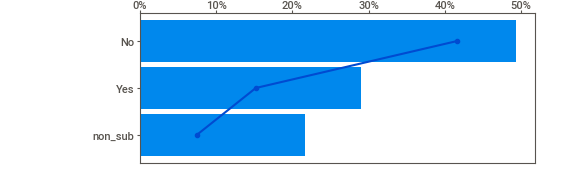
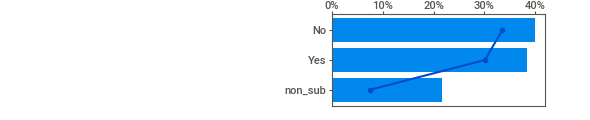
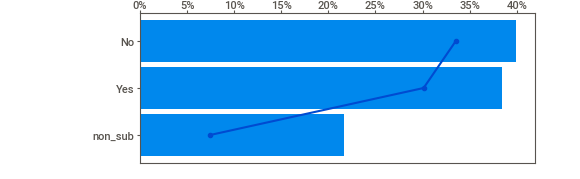
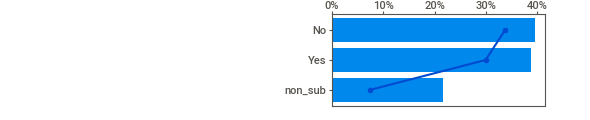
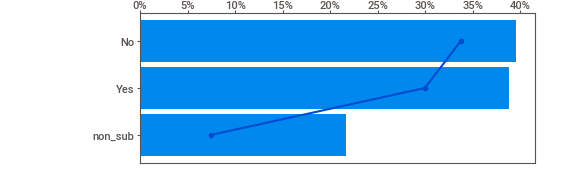
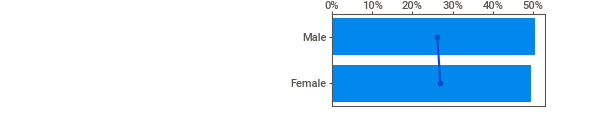
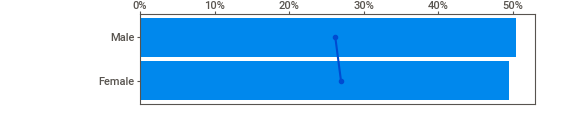
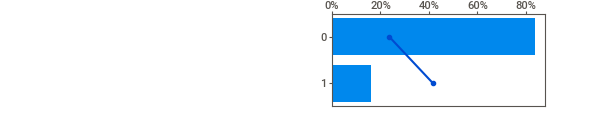
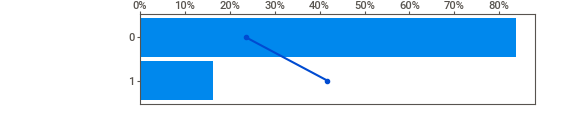
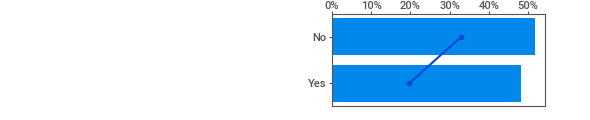
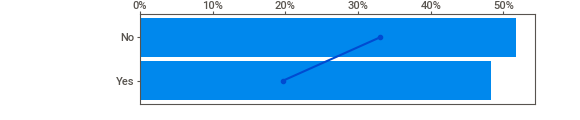
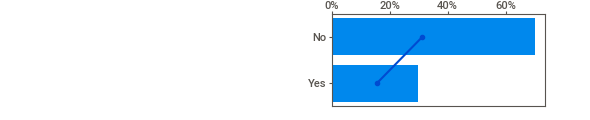
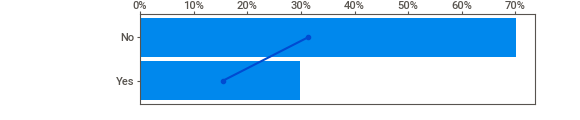
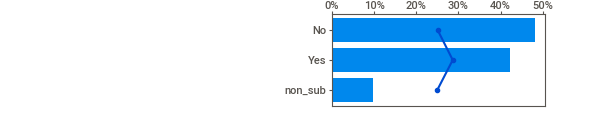
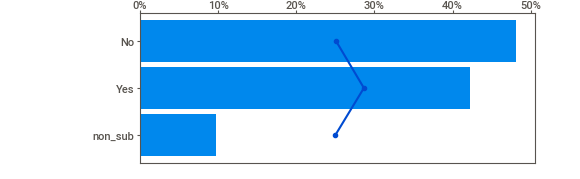
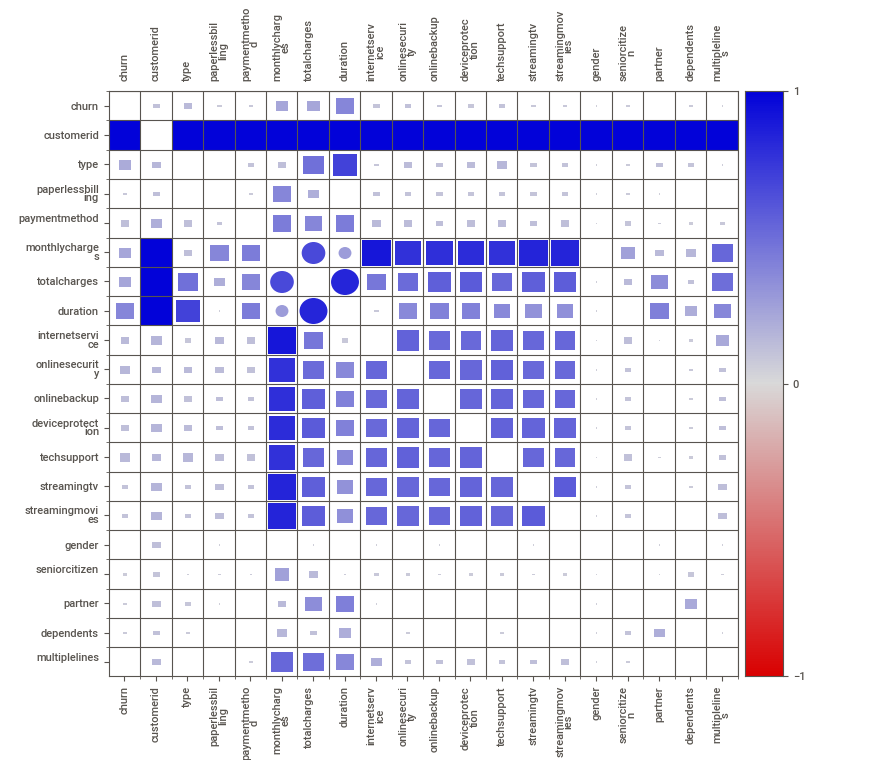
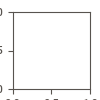

In [38]:
import sweetviz as sv
report = sv.analyze([processed_user, 'All users'], target_feat='churn')
report.show_notebook(layout='vertical', scale='0.97')


### Examine target against individual feature

## TLDR ##

Based on the findings, monthly plan is the most popular plan but comes with high churn rate. Users with below features have higher churn rate:
1. paperless billing
2. enrolled in electronic check payment and fiber optics as internet service
3. did not subscribe to add-on online services such as online security, tech support
4. senior citizen
5. not having dependant

Does not appear there is high correlation between churn and duration, total charges and monthly charges.

Below findings for each feature. 

**type**

This is a categorical data column. Monthly plan is the most popular plan among all users. There are 55% of users on monthly plan; 24% of users on 2 year plan, and 21% of users on 1 year plan.

Churned users account around 40% of monthly plan users. Only 3% of users on 2 year plan have churned. It seems to suggest that the longer we lock in the users for, the higher chance they renew their service with us. **type** column is moderately correlated to the service duration of an user.

<b>Note:</b> It maybe worth exploring and aligning with the goal of the company. Does the management have the goal of increasing annual recurring revenue or do we solely focus on reactivation rate? Monthly users may likely renew for another month so we may have to work on 


**Paperless Billing**

This is another categorical data column. Almost 60% of user opt in for paperless billing and 34% of users that opt in for paperless billing have churned.

**Payment method**

Another cetegorical feature. There are 4 types of payment methods: electronic check, mailed check, bank transfer, credit card. Electronic check is the most popular method and the payment methods are distributed quite evenly amongst the rest other three categories. One thing to note is of 45% of users opt in for electronic check churned. Credit card and bank transfer have lower churn rate perhaps these are automatic.

**Monthly charges**

Numerical feature. The minimum monthly charge is 18 and highest is 119 with average of 65. The most repeated values are in the range of 19 to 21. It has a skew of -0.222 meaning the data is slightly negatively skewed. It has -1.26 KURT indicating platykurtic distribution, meaning fewer outliers.

Monthly charges also has a high correlation with internet service suggesting that likely people with internet service is associated with higher monthly charges.

**Total charges**

Numerical feature. It is postively skewed meaning outliers are on the right. The average total charges is around 2k.


**Duration**

Average subscription is 988 days. Each bin is even distributed except for the first and last bin. Suggesting that we have quite a lot of users that do not want to subscribe for over 300 days but at the same time there is another large group of users that prefers to subscribe for over 2000 days.

**Internet Service**

There are 44% of users chose fiber optic but 44% out of these fiber optic users have churned. There are 34% of users signed up for DSL but only 19% of these users have churned. With fiber optic providing faster internet service which leads to a better browsing experience, over 40% of users still want to churn. There is a very low churn rate at 7% for users that did not subscribe to internet service.      

We should investigate further on our internet service offering. Is there a service issue or there are other competitors with better prices. If it is the former then we should follow up with product team to improve our service in order to stop users churning and capture wider market share.

**Other add-on internet services**

70% of users do not have online security service and it has doubled churn rate at 31% than users that subscribed. For onlinebackup service, the churn rate between subscribers and non-subscribers are similar at around 20-30% similar to device protection. Users that subscribe to tech support also have 50% lower churn rate comparing to those that did not. For streaming TV and movies, there is a higher churn rate for subscribers but only by 6%.


**Gender**

This is an equal split of gener for users and both categories have very similar churn rate.

**Senior citizen**

There are 16% of senior citizen subscribers but of which 42% have churned. Are there other competitors out there that offer cheaper price to senior citizen?

**Partner**

Similar split between having a partner or not. However, not having a partner have a higher churn rate by 8%.

**Dependents and multiple lines**

Not having a dependant have doubled the churn rate than having a dependant. There is a similar churn rate between subscribers and non-subscribers.


### Client outflow research - monthly payment distribution comparison

In [39]:
# Create churn and active users dataframe in preparation of visualisation

active = processed_user.query('churn == 0').describe().iloc[1:]
churned = processed_user.query('churn != 0').describe().iloc[1:]

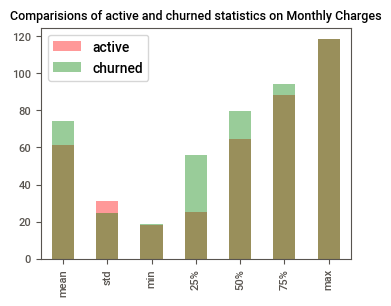

In [40]:
# Create visualisation for the statistics between churn and active users on monthly charges
plt.figure(figsize=(4,3))
active['monthlycharges'].plot(kind='bar', alpha = 0.4, color='r', label='active')
churned['monthlycharges'].plot(kind='bar',alpha = 0.4, color ='g', label='churned')
plt.legend()
plt.title('Comparisions of active and churned statistics on Monthly Charges', fontsize='9')
plt.show()


In [41]:
print('Active users monthly charges statistics')
print(active.loc[active.index,'monthlycharges'])
print('-----------------')
print('Churned users monthly charges statistics')
print(churned.loc[churned.index,'monthlycharges'])

Active users monthly charges statistics
mean     61.307408
std      31.094557
min      18.250000
25%      25.100000
50%      64.450000
75%      88.475000
max     118.750000
Name: monthlycharges, dtype: float64
-----------------
Churned users monthly charges statistics
mean     74.441332
std      24.666053
min      18.850000
25%      56.150000
50%      79.650000
75%      94.200000
max     118.350000
Name: monthlycharges, dtype: float64


The average monthly charges for churned user is around \\$15 higher than active users at \\$74 with 25 percentile of \\$56.

The average monthly charges for active user is \\$61 with 25 percentile of \\$25. The upper percentile and max are relatively similar between classes, suggesting that churned users on average paid a higher monthly charge.

### Client outflow research - total payment distribution comparison

Text(0.5, 1.0, 'Comparisions of active and churned statistics on total charges')

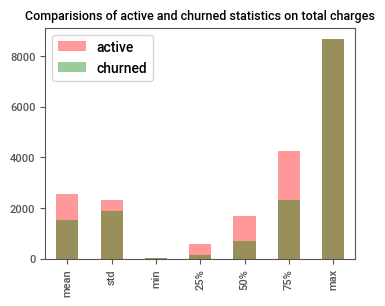

In [42]:
# Create visualisation for the statistics between churn and active users on total charges

plt.figure(figsize=(4,3))
active['totalcharges'].plot(kind='bar', alpha = 0.4, color='r', label='active')
churned['totalcharges'].plot(kind='bar',alpha = 0.4, color ='g', label='churned')
plt.legend()
plt.title('Comparisions of active and churned statistics on total charges', fontsize='9')

In [43]:
print('Active users total charges statistics')
print(active.loc[active.index,'totalcharges'])
print('------------------------')
print('Churn users total charges statistics')
print(churned.loc[churned.index,'totalcharges'])

Active users total charges statistics
mean    2555.344141
std     2329.456984
min       18.800000
25%      577.825000
50%     1683.600000
75%     4264.125000
max     8672.450000
Name: totalcharges, dtype: float64
------------------------
Churn users total charges statistics
mean    1531.796094
std     1890.822994
min       18.850000
25%      134.500000
50%      703.550000
75%     2331.300000
max     8684.800000
Name: totalcharges, dtype: float64


In [44]:
avg_dur_churned = churned['duration'].iloc[0] / 365

print(f'The churned users have an average of {avg_dur_churned:.2f} years of subscription.')

avg_dur_active = active['duration'].iloc[0] / 365

print(f'The active users have an average of {avg_dur_active:.2f} years of subscription.')

The churned users have an average of 1.50 years of subscription.
The active users have an average of 3.14 years of subscription.


The average total charges by churned users is \\$1532 which is lower than active users. Churned users also have an average of 1.5 years of subscription. 

Active users have average total charges of \\$2555 which is 66% higher than churned users. Active users pay less on a monthly basis but eventually their average total charges become higher over the course of time. It could suggest that churned users are willing to pay higher premium to not be locked in for over 1.5 years.

Maybe we should conduct survey when users cancel their services to better understand why they do not want to commit for longer duration.

### Monthly charge for telephone users

In [45]:
# Filter out telephone subscribers

tel_active = processed_user.query('churn == 0 and multiplelines != "non_sub"')
tel_churned = processed_user.query('churn == 1 and multiplelines != "non_sub" ')

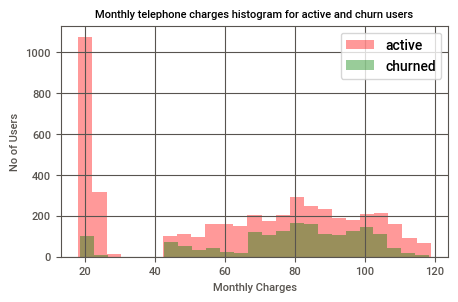

In [46]:
# Histogram for churn and active users for telephone service users monthly charges

plt.figure(figsize=(5,3))
ax = plt.gca()
tel_active.hist('monthlycharges', bins=25, alpha=0.4, color ='r', label = 'active', ax=ax)
tel_churned.hist('monthlycharges', bins=25, alpha=0.4, color = 'g', label='churned', ax=ax)
plt.title('Monthly telephone charges histogram for active and churn users', fontsize='8')
plt.xlabel('Monthly Charges', fontsize='8')
plt.ylabel('No of Users', fontsize='8')
plt.legend()
plt.show()

In [47]:
print('Active users telephone monthly charges statistics')
tel_active_stats = tel_active.describe().iloc[1:]
print(tel_active_stats.loc[tel_active_stats.index,'monthlycharges'])

print('---------------')

print('Churned users telephone monthly charges statistics')
tel_churned_stats = tel_churned.describe().iloc[1:]
print(tel_churned_stats.loc[tel_churned_stats.index,'monthlycharges'])

Active users telephone monthly charges statistics
mean     63.261552
std      31.934310
min      18.250000
25%      24.500000
50%      69.900000
75%      90.050000
max     118.750000
Name: monthlycharges, dtype: float64
---------------
Churned users telephone monthly charges statistics
mean     78.134255
std      22.567643
min      18.850000
25%      69.975000
50%      80.950000
75%      94.850000
max     118.350000
Name: monthlycharges, dtype: float64


There is exceptionally more active users that are paying less than $30 a month on the histogram. Was there a discount campaign ran that attracted these users? How can we replicate the strategy here?

For churn users, there is higher concentration of users between \\$65 to \\$110 suggesting churned users are willing to pay higher for phone services. Are we able to collect more data? One guessing of mine would be are these churn users expats or travelers where they would rather pay higher monthly rates than to be locked in as they may not stay in the country long? Or, are these people making long distance calls? Would love more information to further study. 

The average telephone monthly charges for churned users is \\$78 which is higher than active users at \\$63. Churned users 25 percentile is \\$69 and active users is \\$24 which is significantly lower. The 75 percentile and maximum is similar for both classes.

### Monthly charge for internet users

In [48]:
# Filter out internet subscribers

int_active = processed_user.query('churn == 0 and internetservice != "non_sub"')
int_churned = processed_user.query('churn == 1 and internetservice != "non_sub" ')

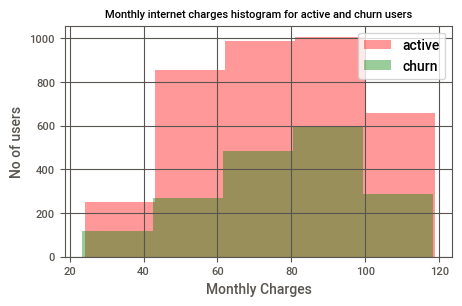

In [49]:
# Histogram for churn and active users for internet service users monthly charges
plt.figure(figsize=(5,3))
ax = plt.gca()
int_active.hist('monthlycharges', bins = 5, alpha = 0.4, color = 'r', label = 'active', ax = ax)
int_churned.hist('monthlycharges', bins = 5, alpha= 0.4, color = 'g', label='churn', ax = ax)
plt.title('Monthly internet charges histogram for active and churn users', fontsize='8')
plt.legend()
plt.xlabel('Monthly Charges')
plt.ylabel('No of users')
plt.show()


In [50]:
print('Active internet monthly charges statistics')
int_active_stats = int_active.describe().iloc[1:]
print(int_active_stats.loc[int_active_stats.index,'monthlycharges'])
print('--' * 50)
print('Churned internet monthly charges statistics')
int_churned_stats = int_churned.describe().iloc[1:]
print(int_churned_stats.loc[int_churned_stats.index,'monthlycharges'])

Active internet monthly charges statistics
mean     76.356709
std      22.272199
min      24.150000
25%      59.137500
50%      78.725000
75%      94.312500
max     118.750000
Name: monthlycharges, dtype: float64
----------------------------------------------------------------------------------------------------
Churned internet monthly charges statistics
mean     77.920985
std      21.144147
min      23.450000
25%      69.350000
50%      80.450000
75%      94.650000
max     118.350000
Name: monthlycharges, dtype: float64


The difference in internet monthly charges is not as variable as telephone charges. The monthly internet charges for churned users has higher concentration between \\$70 and \\$105 while active users  have a mild increasing trend of monthly charges from \\$40 to \\$90 according to the histogram.

The 25 and 75 percentile are close between both groups. The average is only \\$1 difference between both groups.

# Split transform and scale data

Split and scale data **without** encoding. LightGBM and Catboost can handle categorical features

In [51]:
# Create table of features
user_features_cat = processed_user.drop(['churn'], axis=1)

# Create target 

user_target_cat = processed_user['churn']

In [52]:
# Train test split

features_train_c, features_test_c, target_train_c, target_test_c = train_test_split(user_features_cat,
                                                                           user_target_cat,
                                                                           test_size = 0.2,
                                                                            random_state=12345)

In [53]:
# Scale the data

numeric_col = ['monthlycharges', 'totalcharges', 'duration','seniorcitizen']

scaler = StandardScaler()
scaler.fit(features_train_c[numeric_col])

features_train_c[numeric_col] = scaler.transform(features_train_c[numeric_col])
features_test_c[numeric_col] = scaler.transform(features_test_c[numeric_col])


In [54]:
print(features_train_c.shape)
print(target_train_c.shape)
print(features_test_c.shape)
print(target_test_c.shape)

(5625, 19)
(5625,)
(1407, 19)
(1407,)


There are 19 features and 5625 rows of data in training set and 1407 rows of data in testing.

Split and scale data **with** encoding for models such as logistic regression, random forest

In [55]:
# Drop irrelevant roles to create table of features

user_features = processed_user.drop(['churn'], axis=1) 

# Create target 

user_target = processed_user['churn']


**Encoding for categorical columns for decision tree and logistic regression models**

Leverage frequency encoding instead of OHE because OHE will create too many additional features and lead to increase of data size. In addition, having too many 0 in the model will not help with model optimization. It works well with data that has common categories

In [56]:
# Perform frequency encoding to transform categorical feature

cat_cols = ['type',
            'paperlessbilling',
            'paymentmethod',
            'internetservice',
            'onlinesecurity', 
            'onlinebackup',
            'deviceprotection',
            'techsupport',
            'streamingtv',
            'streamingmovies',
            'gender',
            'partner',
            'dependents',
            'multiplelines',
            'customerid']

# Create a loop to iterate all columns to transform into frequency

for each_col in cat_cols:
    frequency = user_features[each_col].value_counts()
    user_features[each_col] = user_features[each_col].map(frequency)
    

In [57]:
# Perform train test split 

features_train, features_test, target_train, target_test = train_test_split(user_features,
                                                                           user_target,
                                                                           test_size = 0.2,
                                                                            random_state=12345)

In [58]:
# Scaling data to make all features to be considered equally important 

numeric = features_train.columns

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])


In [59]:
# Sanity check

user_features.head(3)

,customerid,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,duration,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines
0,1,3875,4168,2365,29.85,29.85,31,2416,3497,2425,3094,3472,2809,2781,3483,0,3393,4933,680
1,1,1472,2864,1604,56.95,1889.50,1036,2416,2015,3087,2418,3472,2809,2781,3549,0,3639,4933,3385
2,1,3875,4168,1604,53.85,108.15,61,2416,2015,2425,3094,3472,2809,2781,3549,0,3639,4933,3385


In [60]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(5625, 19)
(5625,)
(1407, 19)
(1407,)


After splitting the data, there are 5625 rows in the train set and 1407 in the test set.

# Addressing imbalance class of target

<Axes: xlabel='churn'>

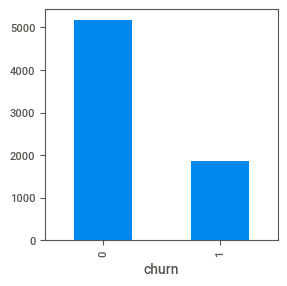

In [61]:
# To visualize imbalance of target once again

plt.figure(figsize=(3,3))
processed_user['churn'].value_counts().plot(kind='bar')


We can see that there is an imbalance of class within our target column, `churn`, in our training data. The number of customers that are active is almost 3 times higher than customers that <b>churned</b>. 

Imbalance of data will make it difficult to train a machine learning model to accurately predict churn because:

- model cannot learn to predict the minority class, churn, well 
- model may only be able to learn simple heuristic; always predict the dominate class, non-churn 
- minority class will become more important than the majority class because a wrong prediction on the minority class can be more costly

We will use SMOTE to address imbalance of class for data we have encoded. With SMOTE, we are creating synthetic data points that are slightly different from the original data points. However, SMOTE does not work with categorical features so we will use upsampling for the set we did not encode. 

In [62]:
# Upsample the minority class using SMOTE for data with encoding 

smote = SMOTE(random_state=12345)

features_train_smote, target_train_smote = smote.fit_resample(features_train, target_train)



<Axes: xlabel='churn'>

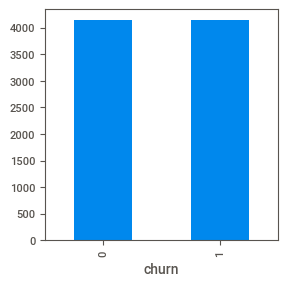

In [63]:
# To examine if the target is now balance

plt.figure(figsize=(3,3))
target_train_smote.value_counts().plot(kind='bar')

In [64]:
# Upsample minority class using RandomOverSampler for data not encoded

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=12345)
features_train_ros, target_train_ros = ros.fit_resample(features_train_c, target_train_c)

<Axes: xlabel='churn'>

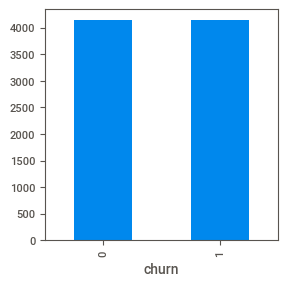

In [65]:
# To examine if the target is now balance

plt.figure(figsize=(3,3))
target_train_ros.value_counts().plot(kind='bar')

We have sucessfully leverage SMOTE to balance our target. Let's create a baseline model.

In [66]:
# Create a table to store auroc score for models

model_score = pd.DataFrame(columns = ["model", "auroc"])

model_score

,model,auroc


# Model 1 Baseline model

Create a baseline model using DummyClassifier as a benchmark for how well models should perform at minimum. DummyClassifier will always predict the majority class which can give better insights of the data. However, since we have already balance out the classes so it should just be 50/50. Alternatively, we can create all zeros by

```python
[0 for _ in range(len(features_test))]
```

In [67]:
# Initiate the model

dummy = DummyClassifier(strategy = 'most_frequent')

dummy.fit(features_train_smote, target_train_smote)

baseline_prob = dummy.predict_proba(features_test)[:,1]



In [68]:
# auroc score

baseline_auroc_score = roc_auc_score(target_test, baseline_prob)

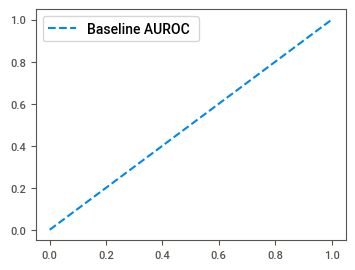

In [69]:
# calcute roc curve for visulisation 

baseline_fpr, baseline_tpr, baseline_threshold = roc_curve(target_test, baseline_prob)

# create the chart
plt.figure(figsize=(4,3))
plt.plot(baseline_fpr, baseline_tpr, linestyle = "--", label = 'Baseline AUROC ' %baseline_auroc_score)
plt.xlabel = ('False Positive Rate')
plt.ylabel = ('True Positive Rate')
plt.legend()
plt.show()

In [70]:
# Storing the score in the table

model_score.loc[0] = ['base line',baseline_auroc_score]

model_score

,model,auroc
0,base line,0.5


# Model 2 Logistic Regression

In [71]:
# Initiate model

lr = LogisticRegression(solver = 'liblinear', random_state=12345)

lr.fit(features_train_smote, target_train_smote)

lr_prod = lr.predict_proba(features_test)[:,1]

In [72]:
# auroc score

lr_auroc_score = roc_auc_score(target_test, lr_prod)
lr_auroc_score

0.850064509219974

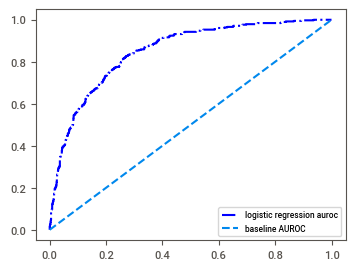

In [73]:
# roc curve for visulisation

lr_fpr, lr_tpr, lr_threshold = roc_curve(target_test, lr_prod)

# Visualising the auroc for Logistic Regression model
plt.figure(figsize=(4,3))
plt.plot(lr_fpr, lr_tpr, linestyle = '-.', color = 'blue', label = 'logistic regression auroc' %lr_auroc_score)
plt.plot(baseline_fpr, baseline_tpr, linestyle = "--", label = 'baseline AUROC ' %baseline_auroc_score)
plt.legend(fontsize=6)
plt.xlabel = ('False Positive Rate')
plt.ylabel = ('True Positive Rate')
plt.show()

In [74]:
model_score.loc[len(model_score)] = ['Logistic Regression', lr_auroc_score]
model_score

,model,auroc
0,base line,0.500000
1,Logistic Regression,0.850065


# Model 3 Random Forest Classifier

Leverage GridSearchCV to find the best parameter

In [75]:
# # Create a dictionary of params

# rf_params = {"n_estimators": np.arange(35,45),
#             "max_depth": np.arange(20,30)}

# # Initiate model 

# rf_model = RandomForestClassifier(random_state=12345)

# # Using GridSearchCV to find the best hyperparameters

# rf_grid = GridSearchCV(rf_model,rf_params, cv=5, n_jobs= -1)

# rf_best_param = rf_grid.fit(features_train_smote, target_train_smote).best_estimator_

# print(f' The best paramaters is {rf_best_param}')

In [76]:
print(f'The best paramaters is RandomForestClassifier(max_depth=21, n_estimators=44, random_state=12345)')

The best paramaters is RandomForestClassifier(max_depth=21, n_estimators=44, random_state=12345)


In [77]:
# Using the best parameters

rf = RandomForestClassifier(max_depth=21, n_estimators=44, random_state=12345)

rf.fit(features_train_smote, target_train_smote)

rf_prob = rf.predict_proba(features_test)[:,1]

In [78]:
# auroc score

rf_auroc_score = roc_auc_score(target_test, rf_prob)
rf_auroc_score

0.8425082612597912

<function matplotlib.pyplot.show(close=None, block=None)>

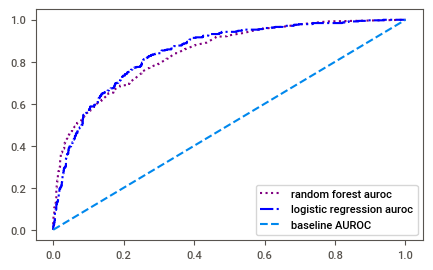

In [79]:
# Getting false positive rate and true positive rate in preparation to plot auroc chart

rf_fpr, rf_tpr, rf_threshold = roc_curve(target_test, rf_prob)

# Plotting the chart
plt.figure(figsize=(5,3))
plt.plot(rf_fpr, rf_tpr, linestyle=':', color='purple', label = 'random forest auroc' %rf_auroc_score )
plt.plot(lr_fpr, lr_tpr, linestyle = '-.', color = 'blue', label = 'logistic regression auroc' %lr_auroc_score)
plt.plot(baseline_fpr, baseline_tpr, linestyle = "--", label = 'baseline AUROC ' %baseline_auroc_score)
plt.legend(fontsize=8)
plt.xlabel = ('False Positive Rate')
plt.ylabel = ('True Positive Rate')
plt.show

In [80]:
model_score.loc[len(model_score)] = ['Random forest', rf_auroc_score]
model_score

,model,auroc
0,base line,0.500000
1,Logistic Regression,0.850065
2,Random forest,0.842508


# Model 4 LightGBM Classifier

Leverage GridSearchCV to find best parameters

In [81]:
# # Dictionary of params

# lgbm_param = {'max_depth' : np.arange(5,10),
#               'n_estimators' : np.arange(10,50,5),
#               'num_leaves': np.arange(20,30),
#              'learning_rate':[0.1*x for x in range (8,10)]}

# lgbm_model = LGBMClassifier(random_state=12345,)

# lgbm_grid = GridSearchCV(lgbm_model, lgbm_param, cv=5, n_jobs=-1)

# lgbm_best = lgbm_grid.fit(features_train_ros, target_train_ros,categorical_feature = 'auto' ).best_params_

In [82]:
print(f'The best hyperparameter for LightGBM is max_depth:8, learning_rate=0.9, n_estimators = 45, num_leaves=28')

The best hyperparameter for LightGBM is max_depth:8, learning_rate=0.9, n_estimators = 45, num_leaves=28


In [83]:
# Initiate model

lgbm = LGBMClassifier(max_depth = 8,
                      learning_rate = 0.9,
                      n_estimators = 45,
                      num_leaves = 28, 
                      objective='binary', 
                      random_state=12345)

lgbm.fit(features_train_ros, target_train_ros, categorical_feature = 'auto')

lgbm_prob = lgbm.predict_proba(features_test_c)[:,1]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 4139, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1515
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

In [84]:
# Getting the auroc score

lgbm_auroc_score = roc_auc_score(target_test_c, lgbm_prob)

lgbm_auroc_score

0.8982845137075719

<function matplotlib.pyplot.show(close=None, block=None)>

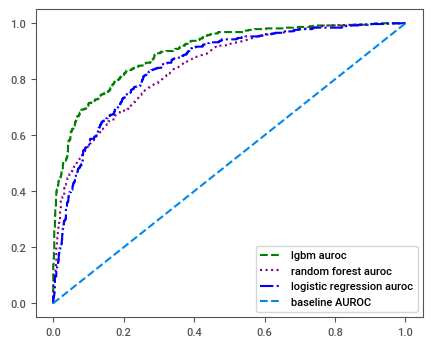

In [85]:
# Getting the false positive rate and true positive rate to plot the chart

lgbm_fpr, lgbm_tpr, lgbm_threshold = roc_curve(target_test_c, lgbm_prob)

# Plotting the auroc chart for lgbm
plt.figure(figsize=(5,4))
plt.plot(lgbm_fpr, lgbm_tpr, linestyle='--', color = 'green', label='lgbm auroc' %lgbm_auroc_score)
plt.plot(rf_fpr, rf_tpr, linestyle=':', color='purple', label = 'random forest auroc' %rf_auroc_score )
plt.plot(lr_fpr, lr_tpr, linestyle = '-.', color = 'blue', label = 'logistic regression auroc' %lr_auroc_score)
plt.plot(baseline_fpr, baseline_tpr, linestyle = "--", label = 'baseline AUROC ' %baseline_auroc_score)
plt.legend(fontsize=8)
plt.xlabel = ('False Positive Rate')
plt.ylabel = ('True Positive Rate')
plt.show


In [86]:
model_score.loc[len(model_score)] = ['LightGBM', lgbm_auroc_score]

model_score

,model,auroc
0,base line,0.500000
1,Logistic Regression,0.850065
2,Random forest,0.842508
3,LightGBM,0.898285


# Model 5 Catboost Classifier

Leverage GridSearchCV to find the best parameters

In [87]:
# # Param dictionary

# catboost_param = {'learning_rate':[0.1*x for x in range (8,10)],
#                  'iterations' : np.arange(40,80,5),
#                   'max_depth': np.arange(2,6)}

# catboost_model = CatBoostClassifier()

# catboost_grid = GridSearchCV(catboost_model, catboost_param, cv = 5, n_jobs = -1)

# catboost_best = catboost_grid.fit(features_train_ros_test, target_train_ros_test, cat_features = cat_cols_test).best_params_

In [88]:
print(f"'The best hyperparameters for catboost is 'iterations': 75, 'learning_rate': 0.8, 'max_depth': 5'")

'The best hyperparameters for catboost is 'iterations': 75, 'learning_rate': 0.8, 'max_depth': 5'


In [89]:
# Initiate model

cb= CatBoostClassifier(iterations=75, learning_rate = 0.8, max_depth = 5, random_state = 12345)

cb.fit(features_train_ros, target_train_ros, cat_features = cat_cols, verbose=0)

# Getting probability for the churn class 
cb_prob = cb.predict_proba(features_test_c)[:,1]

In [90]:
# auroc score for catboost

cb_auroc_score = roc_auc_score(target_test_c, cb_prob)
cb_auroc_score

0.8712633098074413

<function matplotlib.pyplot.show(close=None, block=None)>

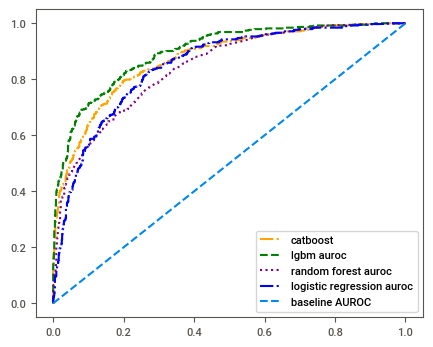

In [91]:
# Getting false positive rate and true positive rate for plotting charts

cb_fpr, cb_tpr, cb_threshold = roc_curve(target_test_c, cb_prob)

# Visualising the ROC curve for catboost
plt.figure(figsize=(5,4))
plt.plot(cb_fpr, cb_tpr, linestyle='-.', color='orange', label='catboost' %cb_auroc_score )
plt.plot(lgbm_fpr, lgbm_tpr, linestyle='--', color = 'green', label='lgbm auroc' %lgbm_auroc_score)
plt.plot(rf_fpr, rf_tpr, linestyle=':', color='purple', label = 'random forest auroc' %rf_auroc_score )
plt.plot(lr_fpr, lr_tpr, linestyle = '-.', color = 'blue', label = 'logistic regression auroc' %lr_auroc_score)
plt.plot(baseline_fpr, baseline_tpr, linestyle = "--", label = 'baseline AUROC ' %baseline_auroc_score)
plt.legend(fontsize=8)
plt.xlabel = ('False Positive Rate')
plt.ylabel = ('True Positive Rate')
plt.show

In [92]:
model_score.loc[len(model_score)] = ['Catboost', cb_auroc_score]
model_score

,model,auroc
0,base line,0.500000
1,Logistic Regression,0.850065
2,Random forest,0.842508
3,LightGBM,0.898285
4,Catboost,0.871263


### Conclusion

First, we created a base line model with DummyClassifier with majority class. The base line model acts as a minimum benchmark for other models. If the other models achieve a lower score than baseline then it would mean they are performing horribly; maybe as worse as guessing by chance. 

We have trained `Logistic Regression`, `Random forest`, `LightGBM`, `Catboost` with `LightGBM` having the best auroc score at 0.89. 

# Model selection and optimal threshold

LightGBM Classifier has the highest roc_auc score. As we have limited resources and would not want to waste our resources on falsely predicted churns, we would want to find the threshold with highest accuracy.

We will find the best threshold and the number of users for marketing team. The threshold can be further tuned with the marketing team if they have more insights. Otherwise, we can provide the first draft for the team to work on.   

Note: Threshold is used to define users' status; active vs churn. In a simple scenario, 0.5 can be the threshold. For example, if the predicted probability for churn is 0.6, we can classify this user as churn. Above 0.5 = churn, below 0.5 = active

In [93]:
# Getting the accuracy score for each threshold produced by LGBM model

accuracy_ls = []
for thres in lgbm_threshold:
    y_pred = np.where(lgbm_prob >thres,1,0)
    accuracy_ls.append(accuracy_score(target_test_c, y_pred, normalize=True))
    


In [94]:
# Create a table of threshold against accuracy

thres_acc = pd.DataFrame(columns = ['threshold', 'accuracy'])

thres_acc['threshold'] = lgbm_threshold
thres_acc['accuracy'] = accuracy_ls

thres_acc = thres_acc.sort_values('accuracy', ascending=False)

In [95]:
# Check the accuracy score for the threshold

thres_acc.head(20)

,threshold,accuracy
98,0.599621,0.859986
99,0.599569,0.859275
97,0.599915,0.859275
96,0.608741,0.858564
94,0.616562,0.858564
106,0.573091,0.858564
92,0.622134,0.858564
90,0.625435,0.858564
88,0.631895,0.858564
89,0.630414,0.857854


We are able to achieve close to 86% accuracy with the first 20 threshold tested. Even though the best accuracy is 0.859986, it has a threshold of 0.599. This means users with 0.599 probability of churn will be considered as churn and may increase the potential number of churn. 

Therefore, I will pick threshold of 0.7138 with accuracy rate of 0.8578 for our first draft to marketing team. We sacrafice an insignificant amount of accuracy score but we can reduce the number of predicted churn to save resources.  

Next step is to find out the list of pential churn users from the active users.

In [96]:
# Filtering out active users

active_list = processed_user.query('churn == 0')
active_list = active_list.drop('churn', axis=1)

In [97]:
# Scaling the data like we did when we trained our models before prediction

numeric_col = ['monthlycharges', 'totalcharges', 'duration','seniorcitizen']

scaler = StandardScaler()
scaler.fit(active_list[numeric_col])

active_list[numeric_col] = scaler.transform(active_list[numeric_col])

In [98]:
# Predicing the probabilty of churn

lgbm_active = lgbm.predict_proba(active_list)[:,1]

In [99]:
# Append the probability to active users list

active_list['predict_proba'] = lgbm_active

In [100]:
# Sanity check of the data

active_list.head(4)

,customerid,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,duration,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines,predict_proba
0,7590-VHVEG,Month-to-month,Yes,Electronic check,-1.011767,-1.084261,-1.522972,DSL,No,Yes,No,No,No,No,Female,-0.384836,Yes,No,non_sub,0.933828
1,5575-GNVDE,One year,No,Mailed check,-0.140148,-0.285864,-0.151338,DSL,Yes,No,Yes,No,No,No,Male,-0.384836,No,No,No,0.000436
3,7795-CFOCW,One year,No,Bank transfer (automatic),-0.611337,-0.306794,0.305874,DSL,Yes,No,Yes,Yes,No,No,Male,-0.384836,No,No,non_sub,0.000329
6,1452-KIOVK,Month-to-month,Yes,Credit card (automatic),0.893895,-0.260148,-0.649494,Fiber optic,No,Yes,No,No,Yes,No,Male,-0.384836,No,Yes,Yes,0.037677


In [101]:
# Assign subscription status base on threshold 0.6096

active_list['predict_churn'] = np.where(active_list['predict_proba'] > 0.7138, 1, 0)

In [102]:
# Getting the number of potential churn

active_list['predict_churn'].value_counts()

predict_churn
0    3898
1    1265
Name: count, dtype: int64

In [103]:
# Risk score of potential churn

low_risk = 0.71
med_risk = 0.80
high_risk = 0.89

active_list['risk_level'] = pd.cut(active_list['predict_proba'],
                                  bins = [0 , low_risk, med_risk, high_risk, 1],
                                  labels= ['no', 'low','medium','high'])

In [104]:
# Number of potential churn base on risk level

active_list['risk_level'].value_counts()

risk_level
no        3896
high       991
medium     145
low        131
Name: count, dtype: int64

With a threshold of 0.7138, there are 991 predicted churning customers. I added in risk level to break down the potential churn customers in 3 categories so marketing team can prioritise users with higher risk with promotions.

In [105]:
# Export to csv for marketing team

active_list.to_csv('potential_churn_list', index = False)

# Conclusion

First of all, we imported all raw data. We removed NAs, merged and filled in new values before performing exploratory data analysis.

By analyzing the datasets, we have found that churn users paid a higer average monthly charge while active users pay higher total charges. Moreover, some other churn users characterstics are:

- paperless billing
- enrolled in electronic check payment and fiber optics as internet service
- did not subscribe to add-on online services such as online security, tech support
- senior citizen
- not having dependant

We studied the behavior for internet and telephone subscribers after studying the pattern of the data. Churned users again pay higher monthly charges for telephone service. 

We encoded (for decision tree and logistic regression models), train test split and scaled data before training model. In addition, we leveraged GridSearchCV to help with fine tuning the hyperparameters. LGBM returned the best auroc score at 0.89. We then tested all threshold to get the accuracy score and decided on threshold of 0.7138 with accuracy score of 0.8578. We further divided the potential churn in three categories so the team can prioritize the high risk users. 

Reflection:

I think the hardest part of the project was the process of exploratory data analysis. It does not seem like churn has a high correlation with the features. However, it was obvious that users with monthly charges have a shorter duration of the service. However, there does not seem to have enough data to suggest the reason. We may have to lean on the marketing team for more information to further investigate.